In [43]:
import os

# Paths relative to the repo root (since notebooks are in the root)
DATA_PROCESSED = "data/processed/"
MODELS_DIR = "models/trained/"
FIGS_DIR = "models/reports/"

# Make sure the folders exist
os.makedirs(DATA_PROCESSED, exist_ok=True)
os.makedirs(MODELS_DIR, exist_ok=True)
os.makedirs(FIGS_DIR, exist_ok=True)


In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix,
    roc_curve, auc
)
from sklearn.model_selection import RandomizedSearchCV

import joblib

# Load dataset
df = pd.read_csv("../data/processed/harties_merged_dataset_nearest.csv")

# Display first rows + shape
print("Dataset shape:", df.shape)
df.head()


Dataset shape: (398, 47)


,mon_feature_id,date_time,sample_begin_depth,institution_abbr,preservative_abbr,Ca_Diss_Water,Ca_Diss_Water_dl,Cl_Diss_Water,Cl_Diss_Water_dl,DMS_Tot_Water,...,TAL_Diss_Water,TAL_Diss_Water_dl,Station,Qat,station_id,NO3_NO2_N_Calc_Water_dl,date,hyacinth_area_m2,hyacinth_percent,hyacinth_present
0,90240,2017-01-18 11:08:00,0.0,DWS-RQIS,HGCL2,45.4,2.5,41.6,2.0,376.152,...,119.8,10.0,A2R001Q01,A21H,90240,NaN,2017-01-18 11:08:00,72832238.4,72.009632,1
1,90240,2017-01-18 11:10:00,0.0,DWS-RQIS,HGCL2,40.1,2.5,41.4,2.0,373.502,...,116.3,10.0,A2R001Q01,A21H,90240,NaN,2017-01-18 11:10:00,72832238.4,72.009632,1
2,90240,2017-01-18 11:12:00,1.0,DWS-RQIS,HGCL2,43.2,2.5,41.7,2.0,385.762,...,127.4,10.0,A2R001Q01,A21H,90240,NaN,2017-01-18 11:12:00,72832238.4,72.009632,1
3,90240,2017-01-18 11:14:00,2.0,DWS-RQIS,HGCL2,43.3,2.5,41.5,2.0,380.801,...,120.6,10.0,A2R001Q01,A21H,90240,NaN,2017-01-18 11:14:00,72832238.4,72.009632,1
4,90240,2017-01-18 11:16:00,5.0,DWS-RQIS,HGCL2,43.9,2.5,42.7,2.0,389.048,...,131.4,10.0,A2R001Q01,A21H,90240,NaN,2017-01-18 11:16:00,72832238.4,72.009632,1


In [45]:
# Convert date column
df['date_time'] = pd.to_datetime(df['date_time'], errors='coerce')

print("Missing values per column:")
print(df.isna().sum())

df_clean = df.copy()
df_clean.head()


Missing values per column:
mon_feature_id               0
date_time                    0
sample_begin_depth          54
institution_abbr             0
preservative_abbr            0
Ca_Diss_Water              139
Ca_Diss_Water_dl           139
Cl_Diss_Water              114
Cl_Diss_Water_dl           114
DMS_Tot_Water              170
DMS_Tot_Water_dl           398
EC_Phys_Water               59
EC_Phys_Water_dl            59
F_Diss_Water                84
F_Diss_Water_dl             84
K_Diss_Water               116
K_Diss_Water_dl            116
KJEL_N_Tot_Water           116
KJEL_N_Tot_Water_dl        116
Mg_Diss_Water              134
Mg_Diss_Water_dl           134
Na_Diss_Water              122
Na_Diss_Water_dl           122
NH4_N_Diss_Water            54
NH4_N_Diss_Water_dl         54
NO3_NO2_N_Diss_Water        55
NO3_NO2_N_Diss_Water_dl     59
P_Tot_Water                118
P_Tot_Water_dl             118
pH_Diss_Water               86
pH_Diss_Water_dl            86
PO4_P_Diss_W

,mon_feature_id,date_time,sample_begin_depth,institution_abbr,preservative_abbr,Ca_Diss_Water,Ca_Diss_Water_dl,Cl_Diss_Water,Cl_Diss_Water_dl,DMS_Tot_Water,...,TAL_Diss_Water,TAL_Diss_Water_dl,Station,Qat,station_id,NO3_NO2_N_Calc_Water_dl,date,hyacinth_area_m2,hyacinth_percent,hyacinth_present
0,90240,2017-01-18 11:08:00,0.0,DWS-RQIS,HGCL2,45.4,2.5,41.6,2.0,376.152,...,119.8,10.0,A2R001Q01,A21H,90240,NaN,2017-01-18 11:08:00,72832238.4,72.009632,1
1,90240,2017-01-18 11:10:00,0.0,DWS-RQIS,HGCL2,40.1,2.5,41.4,2.0,373.502,...,116.3,10.0,A2R001Q01,A21H,90240,NaN,2017-01-18 11:10:00,72832238.4,72.009632,1
2,90240,2017-01-18 11:12:00,1.0,DWS-RQIS,HGCL2,43.2,2.5,41.7,2.0,385.762,...,127.4,10.0,A2R001Q01,A21H,90240,NaN,2017-01-18 11:12:00,72832238.4,72.009632,1
3,90240,2017-01-18 11:14:00,2.0,DWS-RQIS,HGCL2,43.3,2.5,41.5,2.0,380.801,...,120.6,10.0,A2R001Q01,A21H,90240,NaN,2017-01-18 11:14:00,72832238.4,72.009632,1
4,90240,2017-01-18 11:16:00,5.0,DWS-RQIS,HGCL2,43.9,2.5,42.7,2.0,389.048,...,131.4,10.0,A2R001Q01,A21H,90240,NaN,2017-01-18 11:16:00,72832238.4,72.009632,1


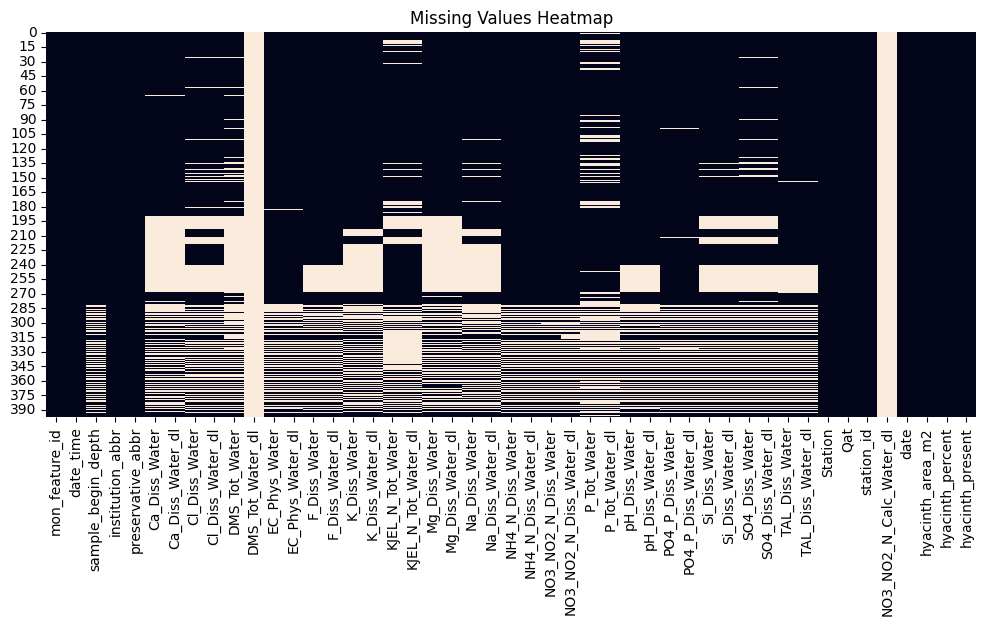

In [46]:
plt.figure(figsize=(12,5))
sns.heatmap(df_clean.isna(), cbar=False)
plt.title("Missing Values Heatmap")
plt.show()


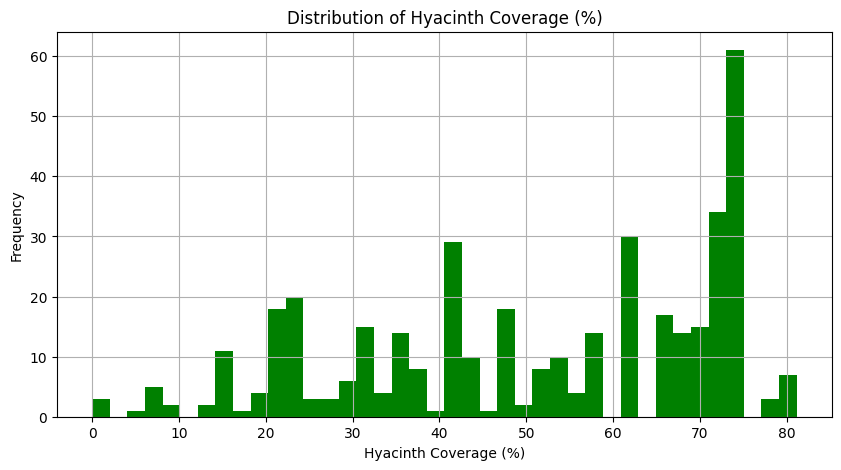

In [47]:
plt.figure(figsize=(10,5))
df_clean['hyacinth_percent'].hist(bins=40, color='green')
plt.title("Distribution of Hyacinth Coverage (%)")
plt.xlabel("Hyacinth Coverage (%)")
plt.ylabel("Frequency")
plt.show()


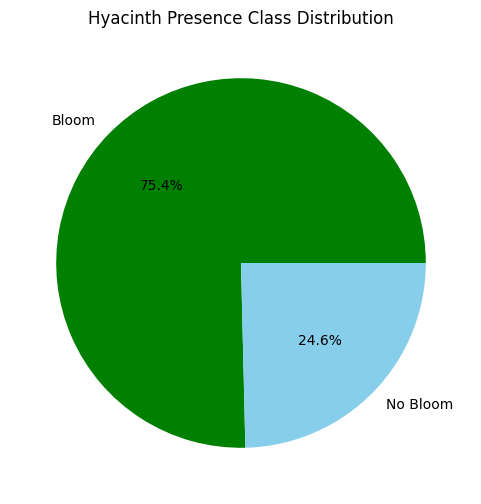

In [48]:
plt.figure(figsize=(6,6))

df['hyacinth_present'].value_counts().plot(
    kind='pie',
    autopct='%1.1f%%',
    labels=['Bloom', 'No Bloom'] if df['hyacinth_present'].value_counts().index[0] == 1 else ['No Bloom','Bloom'],
    colors=['green', 'skyblue']
)

plt.title("Hyacinth Presence Class Distribution")
plt.ylabel("")
plt.show()


In [49]:
import numpy as np

features = [
    'EC_Phys_Water',
    'pH_Diss_Water',
    'PO4_P_Diss_Water',
    'NO3_NO2_N_Diss_Water',
    'NH4_N_Diss_Water'
]

# Work on a copy
df_clean = df_clean.copy()

# Replace '#n/a' with NaN and convert to float for each feature
for col in features:
    df_clean[col] = (
        df_clean[col]
        .replace('#n/a', np.nan)
        .astype(str)              # in case of mixed types
        .str.replace(',', '.', regex=False)  # if decimal commas exist
    )
    df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')

# Also make sure hyacinth_present is numeric
df_clean['hyacinth_present'] = pd.to_numeric(
    df_clean['hyacinth_present'], errors='coerce'
)


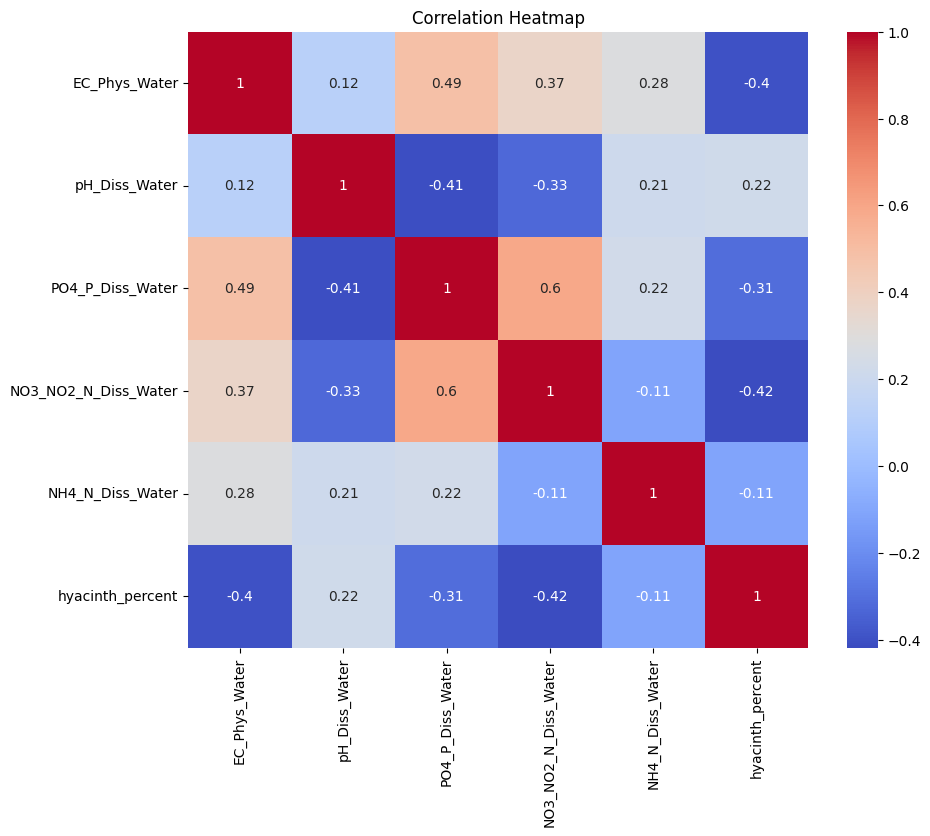

In [50]:
plt.figure(figsize=(10,8))
corr = df_clean[['EC_Phys_Water','pH_Diss_Water','PO4_P_Diss_Water',
                 'NO3_NO2_N_Diss_Water','NH4_N_Diss_Water','hyacinth_percent']].corr()

sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()


In [51]:
features = [
    'EC_Phys_Water',
    'pH_Diss_Water',
    'PO4_P_Diss_Water',
    'NO3_NO2_N_Diss_Water',
    'NH4_N_Diss_Water'
]

df_model = df_clean.dropna(subset=features + ['hyacinth_present'])

X = df_model[features]
y = df_model['hyacinth_present'].astype(int)




In [52]:
!pip install imbalanced-learn


Defaulting to user installation because normal site-packages is not writeable


In [53]:
print("Class balance BEFORE filtering/SMOTE:")
print(y.value_counts())


Class balance BEFORE filtering/SMOTE:
hyacinth_present
1    240
0     63
Name: count, dtype: int64


In [54]:
from imblearn.over_sampling import RandomOverSampler

features = [
    'EC_Phys_Water',
    'pH_Diss_Water',
    'PO4_P_Diss_Water',
    'NO3_NO2_N_Diss_Water',
    'NH4_N_Diss_Water'
]

df_model = df_clean.dropna(subset=features + ['hyacinth_present'])

X = df_model[features]
y = df_model['hyacinth_present'].astype(int)

print("Class balance BEFORE oversampling:")
print(y.value_counts())

# ===========================
# 🔥 Random oversampling here
# ===========================
ros = RandomOverSampler(random_state=42)
X_sm, y_sm = ros.fit_resample(X, y)

print("\nClass balance AFTER oversampling:")
print(y_sm.value_counts())

# ===========================
# 🔥 Train/test split
# ===========================
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score, f1_score


tscv = TimeSeriesSplit(n_splits=5)

fold = 1
for train_index, test_index in tscv.split(X_sm):
    print(f"\n🔹 Fold {fold}")
    fold += 1

    # Use iloc to select ROWS by position
    X_train = X_sm.iloc[train_index]
    X_test  = X_sm.iloc[test_index]
    y_train = y_sm.iloc[train_index]
    y_test  = y_sm.iloc[test_index]

    # Fit your classifier inside the loop
    clf = RandomForestClassifier(random_state=42)
    clf.fit(X_train, y_train)

    preds = clf.predict(X_test)

    print("Accuracy:", accuracy_score(y_test, preds))
    print("F1 Score:", f1_score(y_test, preds))



print("\nTrain distribution:\n", y_train.value_counts())
print("\nTest distribution:\n", y_test.value_counts())


Class balance BEFORE oversampling:
hyacinth_present
1    240
0     63
Name: count, dtype: int64

Class balance AFTER oversampling:
hyacinth_present
1    240
0    240
Name: count, dtype: int64

🔹 Fold 1


Accuracy: 0.5125
F1 Score: 0.6776859504132231

🔹 Fold 2
Accuracy: 0.95
F1 Score: 0.974025974025974

🔹 Fold 3
Accuracy: 0.7
F1 Score: 0.7735849056603774

🔹 Fold 4
Accuracy: 1.0
F1 Score: 0.0

🔹 Fold 5
Accuracy: 1.0
F1 Score: 0.0

Train distribution:
 hyacinth_present
1    240
0    160
Name: count, dtype: int64

Test distribution:
 hyacinth_present
0    80
Name: count, dtype: int64


/home/user/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/user/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


In [55]:
param_dist = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [4, 6, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

rf = RandomForestClassifier(random_state=42)

search = RandomizedSearchCV(
    rf, param_distributions=param_dist, n_iter=20,
    scoring='f1', cv=3, random_state=42, n_jobs=-1
)

search.fit(X_train, y_train)

best_model = search.best_estimator_
print("Best Parameters:", search.best_params_)


Best Parameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 4, 'bootstrap': False}


In [56]:
y_pred = best_model.predict(X_test)

print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.94      0.97        80
           1       0.00      0.00      0.00         0

    accuracy                           0.94        80
   macro avg       0.50      0.47      0.48        80
weighted avg       1.00      0.94      0.97        80

Confusion Matrix:
 [[75  5]
 [ 0  0]]


/home/user/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/user/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/user/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:1273: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(aggregator, agg_var)


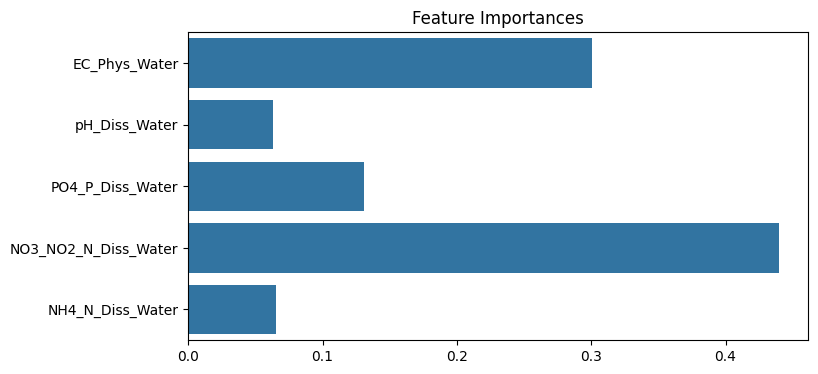

In [57]:
importances = best_model.feature_importances_
plt.figure(figsize=(8,4))
sns.barplot(x=importances, y=features)
plt.title("Feature Importances")
plt.show()


In [58]:
model = RandomForestClassifier()
model.fit(X_train, y_train)


,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


/home/user/.local/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:1201: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


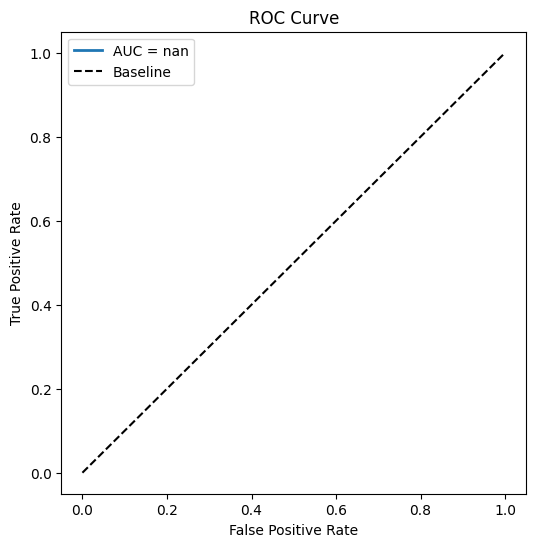

In [59]:
from sklearn.metrics import roc_curve, auc

# Predict probabilities for the positive class (bloom = 1)
y_prob = model.predict_proba(X_test)[:, 1]  # or best_model if that's what you used

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}", linewidth=2)
plt.plot([0,1], [0,1], 'k--', label="Baseline")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


In [60]:
risk_model_path = os.path.join(MODELS_DIR, "hyacinth_risk_model.joblib")
joblib.dump(best_model, risk_model_path)

features_path = os.path.join(FIGS_DIR, "model_features.csv")
pd.Series(features).to_csv(features_path, index=False)

print("Model + Feature List Saved.")


Model + Feature List Saved.


In [61]:
sample = X_test.iloc[0]
pred = best_model.predict([sample])[0]
prob = best_model.predict_proba([sample])[0][1]

print("Input Values:\n", sample)
print("\nPrediction:", "Bloom" if pred==1 else "No Bloom")
print("Probability of Bloom:", round(prob*100, 2), "%")


Input Values:
 EC_Phys_Water           65.920
pH_Diss_Water            7.110
PO4_P_Diss_Water         1.331
NO3_NO2_N_Diss_Water    12.367
NH4_N_Diss_Water         0.119
Name: 400, dtype: float64

Prediction: No Bloom
Probability of Bloom: 24.77 %


/home/user/.local/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/user/.local/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [62]:
!pip install xgboost prophet


Defaulting to user installation because normal site-packages is not writeable


In [63]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.7,
    eval_metric="logloss"
)

xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

print("XGBoost Classification Report:\n", classification_report(y_test, y_pred_xgb))


XGBoost Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        80

    accuracy                           1.00        80
   macro avg       1.00      1.00      1.00        80
weighted avg       1.00      1.00      1.00        80



In [64]:
from sklearn.linear_model import LogisticRegression

log_model = LogisticRegression(max_iter=500)
log_model.fit(X_train, y_train)
y_pred_log = log_model.predict(X_test)

print("Logistic Regression Report:\n", classification_report(y_test, y_pred_log))


Logistic Regression Report:
               precision    recall  f1-score   support

           0       1.00      0.85      0.92        80
           1       0.00      0.00      0.00         0

    accuracy                           0.85        80
   macro avg       0.50      0.42      0.46        80
weighted avg       1.00      0.85      0.92        80



/home/user/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/user/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/user/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


In [65]:
from sklearn.metrics import f1_score, accuracy_score

results = {
    "Random Forest": {
        "Accuracy": accuracy_score(y_test, best_model.predict(X_test)),
        "F1": f1_score(y_test, best_model.predict(X_test))
    },
    "XGBoost": {
        "Accuracy": accuracy_score(y_test, y_pred_xgb),
        "F1": f1_score(y_test, y_pred_xgb)
    },
    "Logistic Regression": {
        "Accuracy": accuracy_score(y_test, y_pred_log),
        "F1": f1_score(y_test, y_pred_log)
    }
}

pd.DataFrame(results).T


/home/user/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


,Accuracy,F1
Random Forest,0.9375,0.0
XGBoost,1.0000,0.0
Logistic Regression,0.8500,0.0


In [66]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

df_reg = df_clean.dropna(subset=features + ['hyacinth_percent'])

Xr = df_reg[features]
yr = df_reg['hyacinth_percent']

tscv = TimeSeriesSplit(n_splits=5)

fold = 1
for train_index, test_index in tscv.split(Xr):
    print(f"\n🌿 Regression Fold {fold}")
    fold += 1

    Xr_train = Xr.iloc[train_index]
    Xr_test  = Xr.iloc[test_index]
    yr_train = yr.iloc[train_index]
    yr_test  = yr.iloc[test_index]

    reg_model = RandomForestRegressor()
    reg_model.fit(Xr_train, yr_train)

    yr_pred = reg_model.predict(Xr_test)

    print("MAE:", mean_absolute_error(yr_test, yr_pred))
    print("R²:", r2_score(yr_test, yr_pred))





🌿 Regression Fold 1


MAE: 22.763000339931928
R²: -1.5507769967442049

🌿 Regression Fold 2
MAE: 11.339920696456009
R²: -0.05917252000300954

🌿 Regression Fold 3
MAE: 17.375015121406047
R²: -27.104101651067985

🌿 Regression Fold 4
MAE: 17.327869480678444
R²: -0.40419952808138815

🌿 Regression Fold 5
MAE: 20.19228379250647
R²: -0.7497077248430151


/tmp/ipykernel_54546/1865842694.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances_r, y=features, palette="viridis")
/usr/local/lib/python3.11/dist-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:1273: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply

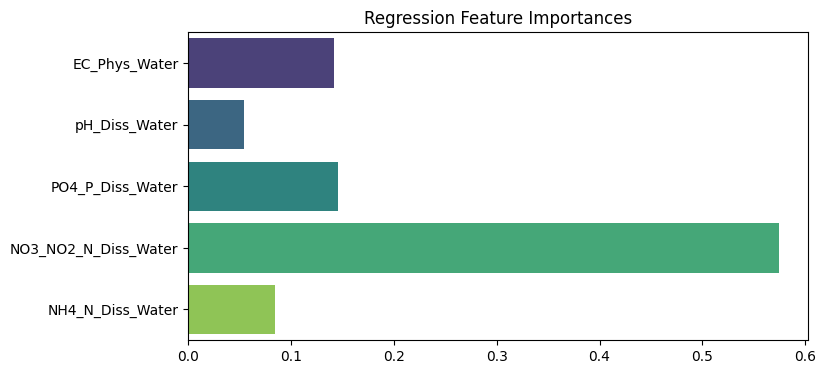

In [67]:
importances_r = reg_model.feature_importances_

plt.figure(figsize=(8,4))
sns.barplot(x=importances_r, y=features, palette="viridis")
plt.title("Regression Feature Importances")
plt.show()


In [68]:
ts = df_clean[['date','hyacinth_percent']].dropna().copy()
ts = ts.sort_values('date')

ts = ts.rename(columns={'date':'ds','hyacinth_percent':'y'})
ts.head()


,ds,y
0,2017-01-18 11:08:00,72.009632
1,2017-01-18 11:10:00,72.009632
2,2017-01-18 11:12:00,72.009632
3,2017-01-18 11:14:00,72.009632
4,2017-01-18 11:16:00,72.009632


14:51:51 - cmdstanpy - INFO - Chain [1] start processing
14:51:51 - cmdstanpy - INFO - Chain [1] done processing
/usr/local/lib/python3.11/dist-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/usr/local/lib/python3.11/dist-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


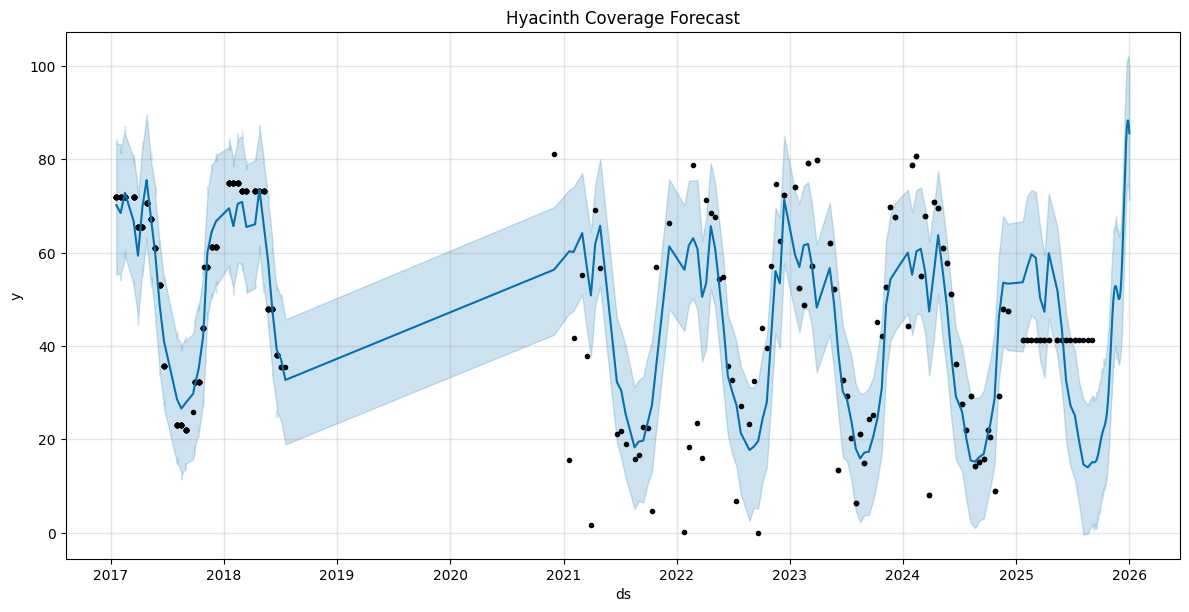

In [69]:
from prophet import Prophet

model_prophet = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False
)

model_prophet.fit(ts)

future = model_prophet.make_future_dataframe(periods=120)  # Forecast 120 days ahead
forecast = model_prophet.predict(future)

model_prophet.plot(forecast, figsize=(12,6))
plt.title("Hyacinth Coverage Forecast")
plt.show()


/usr/local/lib/python3.11/dist-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/usr/local/lib/python3.11/dist-packages/prophet/plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
/usr/local/lib/python3.11/dist-packages/prophet/plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` o

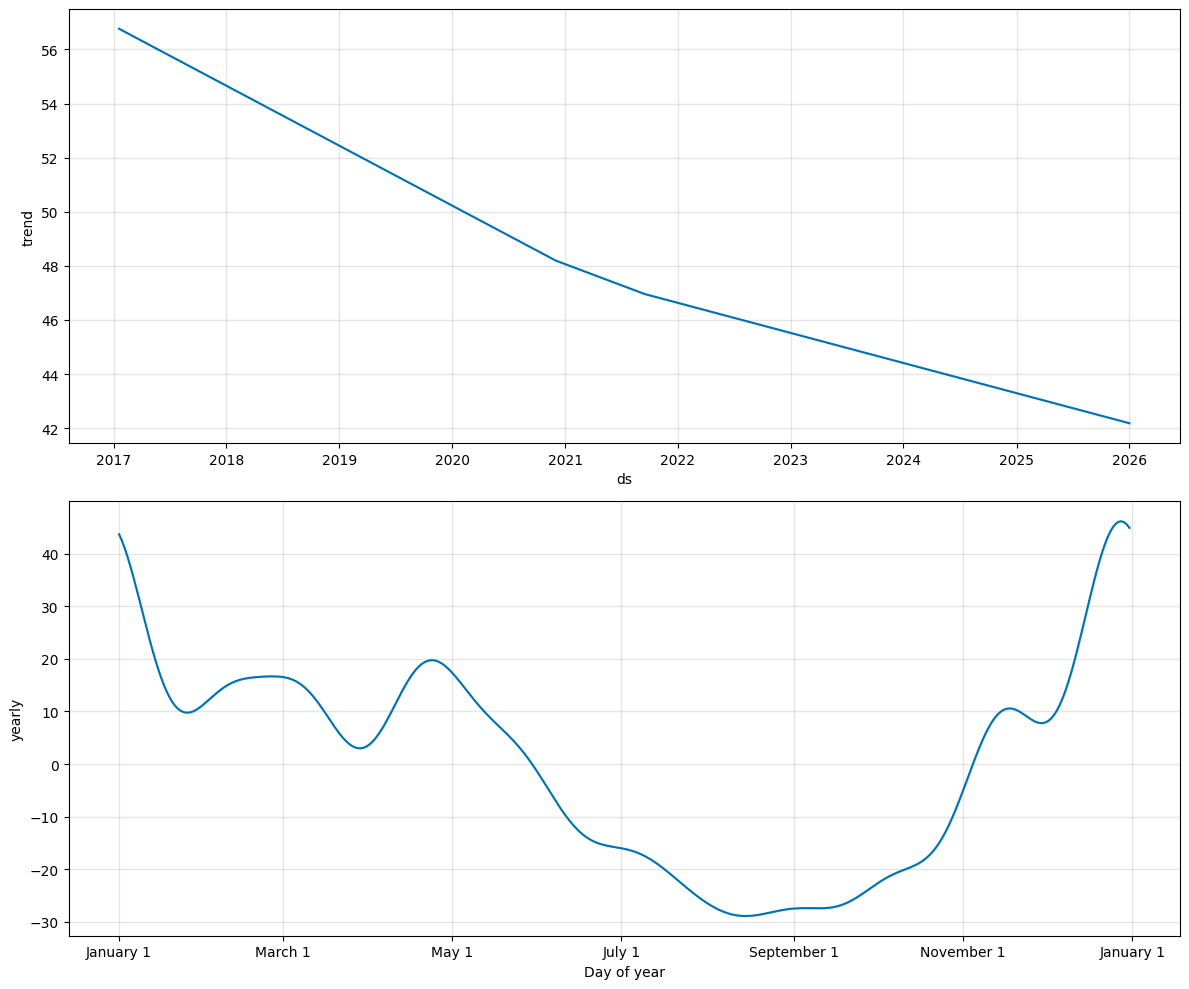

In [70]:
model_prophet.plot_components(forecast, figsize=(12,10))
plt.show()


In [71]:
rf_path = os.path.join(MODELS_DIR, "model_random_forest.joblib")
xgb_path = os.path.join(MODELS_DIR, "model_xgboost.joblib")
log_path = os.path.join(MODELS_DIR, "model_logistic.joblib")
reg_path = os.path.join(MODELS_DIR, "model_regression.joblib")

joblib.dump(best_model, rf_path)
joblib.dump(xgb_model, xgb_path)
joblib.dump(log_model, log_path)
joblib.dump(reg_model, reg_path)

forecast_path = os.path.join(DATA_PROCESSED, "hyacinth_forecast.csv")
forecast[['ds','yhat','yhat_lower','yhat_upper']].to_csv(forecast_path, index=False)

print("All models and forecast exported.")


All models and forecast exported.
